In [ ]:
import os
import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from tqdm.notebook import tqdm
import random

# Configuration
WORK_DIR = "/kaggle/working/classifier_dataset"
SIGNAL_DIR = os.path.join(WORK_DIR, "Signal")
BG_DIR = os.path.join(WORK_DIR, "Background")

# Clean and create directories
if os.path.exists(WORK_DIR): shutil.rmtree(WORK_DIR)
os.makedirs(SIGNAL_DIR)
os.makedirs(BG_DIR)
print(f"Working directory created: {WORK_DIR}")

# Find Gravity Spy Dataset
gspy_roots = glob.glob("/kaggle/input/**/train/train", recursive=True)
if not gspy_roots:
    # Alternative path
    gspy_roots = glob.glob("/kaggle/input/**/gravity_spy/train/train", recursive=True)

if gspy_roots:
    GSPY_PATH = gspy_roots[0]
    print(f"Gravity Spy found: {GSPY_PATH}")
    
    # Copy glitch classes
    classes = [d for d in os.listdir(GSPY_PATH) if os.path.isdir(os.path.join(GSPY_PATH, d))]
    print(f"Copying {len(classes)} glitch classes...")
    
    for c in tqdm(classes, desc="Linking Glitches"):
        os.makedirs(f"{WORK_DIR}/{c}", exist_ok=True)
        # Take random 250 images per class to balance dataset
        src_imgs = glob.glob(f"{GSPY_PATH}/{c}/*.png") + glob.glob(f"{GSPY_PATH}/{c}/*.jpg")
        random.shuffle(src_imgs)
        for img in src_imgs[:250]:
            shutil.copy(img, f"{WORK_DIR}/{c}/")
else:
    print("Gravity Spy dataset not found.")

# Generate Background from .npy files
print("Generating Background Samples...")
npy_files = glob.glob("/kaggle/input/**/*.npy", recursive=True)
# Filter for data chunks
npy_files = [f for f in npy_files if "chunk" in f.lower()]

def save_spec_image(data, path):
    plt.figure(figsize=(2.24, 2.24), dpi=100)
    plt.axis('off'); plt.margins(0,0)
    f, t, Sxx = signal.spectrogram(data, fs=2048, nperseg=128, noverlap=120)
    plt.pcolormesh(t, f, np.log10(Sxx + 1e-10), shading='gouraud', cmap='viridis', vmin=-11, vmax=-7)
    plt.savefig(path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Generate 250 background images
for i in tqdm(range(250), desc="Gen Background"):
    try:
        if npy_files:
            # Load real noise
            f = random.choice(npy_files)
            data = np.load(f)
            idx = random.randint(0, len(data)-1)
            wave = data[idx].flatten()
        else:
            # Synthetic fallback
            wave = np.random.normal(0, 1, 2048)
        save_spec_image(wave, f"{BG_DIR}/bg_{i}.jpg")
    except: continue

# Generate Signal Class (Chirps)
print("Generating Synthetic Signals (Chirps)...")
t = np.linspace(0, 1, 2048)
for i in tqdm(range(250), desc="Gen Signals"):
    # Random chirp parameters
    f_start = np.random.uniform(20, 50)
    f_end = np.random.uniform(200, 400)
    amp = np.random.uniform(3, 8)
    
    clean_sig = signal.chirp(t, f0=f_start, f1=f_end, t1=1.0, method='quadratic')
    envelope = np.exp(2 * t) / np.exp(2) # Rising envelope
    sig = amp * clean_sig * envelope
    
    # Add background noise
    noise = np.random.normal(0, 1, 2048)
    final_wave = noise + sig
    save_spec_image(final_wave, f"{SIGNAL_DIR}/sig_{i}.jpg")

print("Dataset generation complete at: /kaggle/working/classifier_dataset")

🔨 Рабочая папка создана: /kaggle/working/classifier_dataset
✅ Gravity Spy найден: /kaggle/input/datasets/tentotheminus9/gravity-spy-gravitational-waves/train/train
   Копирую 22 классов глитчей...


Linking Glitches:   0%|          | 0/22 [00:00<?, ?it/s]

🖼️ Генерируем Background...


Gen Background:   0%|          | 0/250 [00:00<?, ?it/s]

🌊 Генерируем Signals (Chirps)...


Gen Signals:   0%|          | 0/250 [00:00<?, ?it/s]


🎉 ГОТОВО! Датасет собран в /kaggle/working/classifier_dataset


In [ ]:
# Data Inspection: Sample Efficiency
# Visualization of random samples from different classes to verify data integrity.
def visualize_samples(data_dir, num_classes=5, samples_per_class=3):
    classes = sorted(os.listdir(data_dir))
    if not classes: return
    
    selected_classes = np.random.choice(classes, min(len(classes), num_classes), replace=False)
    
    fig, axes = plt.subplots(len(selected_classes), samples_per_class, figsize=(10, 2*len(selected_classes)))
    plt.subplots_adjust(hspace=0.5)
    
    for i, cls in enumerate(selected_classes):
        cls_path = os.path.join(data_dir, cls)
        imgs = glob.glob(os.path.join(cls_path, "*.jpg")) + glob.glob(os.path.join(cls_path, "*.png"))
        
        if len(imgs) >= samples_per_class:
            selected_imgs = np.random.choice(imgs, samples_per_class, replace=False)
            for j, img_path in enumerate(selected_imgs):
                ax = axes[i, j] if len(selected_classes) > 1 else axes[j]
                img = plt.imread(img_path)
                ax.imshow(img)
                ax.axis('off')
                if j == 0:
                    ax.set_title(cls, fontsize=10, fontweight='bold', loc='left')
    plt.suptitle("Random Dataset Samples", fontsize=14)
    plt.show()

print("Visualizing Training Data Samples...")
if os.path.exists(WORK_DIR):
    visualize_samples(WORK_DIR)

In [ ]:
# Data Inspection: Class Distribution
# Analyzes the balance of the dataset to identify potential biases.
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob

def plot_class_distribution(data_dir):
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    counts = []
    
    for c in classes:
        c_path = os.path.join(data_dir, c)
        num_files = len(glob.glob(os.path.join(c_path, "*")))
        counts.append(num_files)
        
    # Sort for better readability
    sorted_pairs = sorted(zip(counts, classes), reverse=True)
    counts, classes = zip(*sorted_pairs)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(classes), y=list(counts), palette='viridis')
    plt.xticks(rotation=90)
    plt.title("Class Distribution in Dataset")
    plt.ylabel("Number of Samples")
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

if os.path.exists(WORK_DIR):
    plot_class_distribution(WORK_DIR)

2026-02-14 02:32:25.307268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771036345.874337      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771036345.997729      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771036347.106342      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771036347.106385      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771036347.106388      24 computation_placer.cc:177] computation placer alr

📂 Загружаем данные из: /kaggle/working/classifier_dataset
📊 Формируем тренировочный и валидационный сеты...
Found 5484 files belonging to 24 classes.
Using 4388 files for training.


I0000 00:00:1771036367.384528      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 5484 files belonging to 24 classes.
Using 1096 files for validation.

✅ Классов найдено: 24
Список классов: ['1080Lines', '1400Ripples', 'Air_Compressor', 'Background', 'Blip', 'Chirp', 'Extremely_Loud', 'Helix', 'Koi_Fish', 'Light_Modulation', 'Low_Frequency_Burst', 'Low_Frequency_Lines', 'No_Glitch', 'None_of_the_Above', 'Paired_Doves', 'Power_Line', 'Repeating_Blips', 'Scattered_Light', 'Scratchy', 'Signal', 'Tomte', 'Violin_Mode', 'Wandering_Line', 'Whistle']

🏗️ Строим модель (Transfer Learning)...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "Singularity_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │        30,744 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,080,315 (15.57 MB)

 Trainable params: 30,744 (120.09 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


🚀 СТАРТ ОБУЧЕНИЯ (10 эпох)...
Epoch 1/10


I0000 00:00:1771036394.325720      73 service.cc:152] XLA service 0x7b7eb014d5e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771036394.325759      73 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771036396.635293      73 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1771036408.789733      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


138/138 ━━━━━━━━━━━━━━━━━━━━ 66s 222ms/step - accuracy: 0.2948 - loss: 2.3906 - val_accuracy: 0.5958 - val_loss: 1.4792
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.6122 - loss: 1.3966 - val_accuracy: 0.6770 - val_loss: 1.1741
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.6613 - loss: 1.1682 - val_accuracy: 0.7235 - val_loss: 1.0227
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7084 - loss: 1.0286 - val_accuracy: 0.7454 - val_loss: 0.9303
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7398 - loss: 0.9130 - val_accuracy: 0.7710 - val_loss: 0.8578
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7464 - loss: 0.8763 - val_accuracy: 0.7646 - val_loss: 0.8230
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7597 - loss: 0.8284 - val_accuracy: 0.7947 - val_loss: 0.7789
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7806 - loss: 0.7820 - val_accuracy: 0.7

2026-02-14 02:35:02.547724: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-14 02:35:02.753599: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


138/138 ━━━━━━━━━━━━━━━━━━━━ 54s 204ms/step - accuracy: 0.5901 - loss: 1.3940 - val_accuracy: 0.7354 - val_loss: 0.8168
Epoch 11/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.6912 - loss: 1.0300 - val_accuracy: 0.7536 - val_loss: 0.7808
Epoch 12/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7288 - loss: 0.8972 - val_accuracy: 0.7783 - val_loss: 0.7265
Epoch 13/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7611 - loss: 0.8037 - val_accuracy: 0.7938 - val_loss: 0.6857
Epoch 14/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7653 - loss: 0.7577 - val_accuracy: 0.8038 - val_loss: 0.6534
Epoch 15/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7864 - loss: 0.7173 - val_accuracy: 0.8084 - val_loss: 0.6271


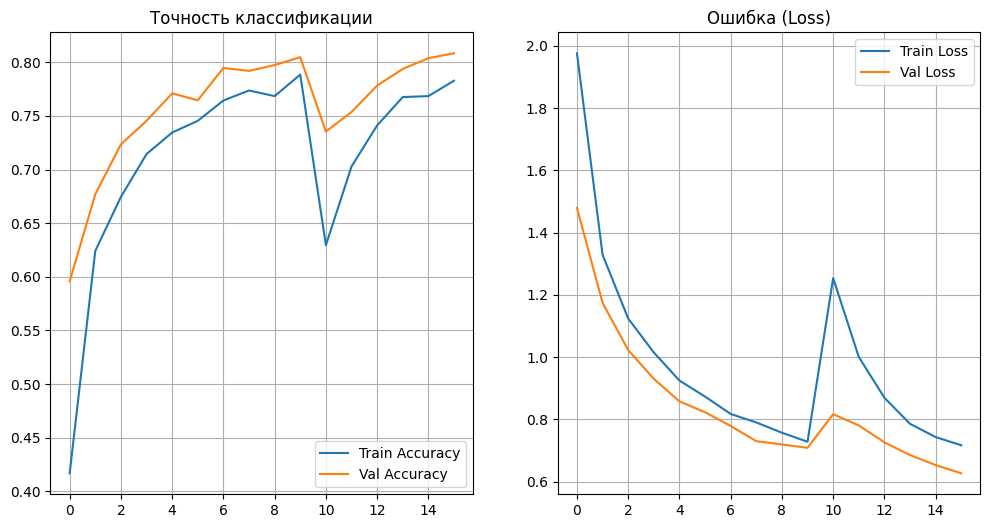


🔍 Строим Матрицу Ошибок...


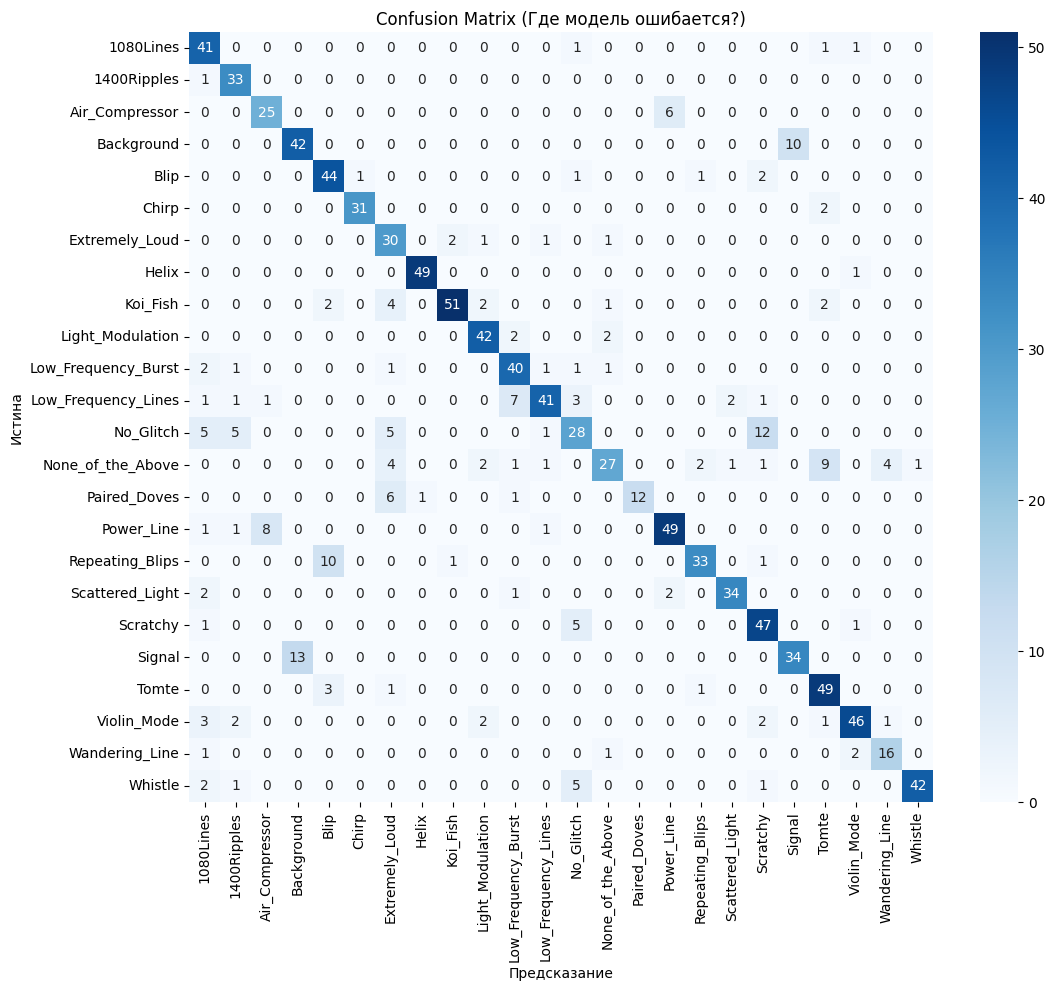

✅ Модель сохранена в singularity_classifier_final.keras


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

# Parameters
DATA_DIR = "/kaggle/working/classifier_dataset"
IMG_SIZE = (224, 224) 
BATCH_SIZE = 32       
EPOCHS = 10           
LEARNING_RATE = 1e-3

print(f"Loading data from: {DATA_DIR}")

if not os.path.exists(DATA_DIR) or len(os.listdir(DATA_DIR)) < 3:
    raise FileNotFoundError("Dataset not found. Please run the generation step first.")

# Load Data (with automatic split)
print("Creating training and validation sets...")

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Classes found: {num_classes}")
print(f"Class list: {class_names}")

# Performance Optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Definition (EfficientNetB0)
print("Building model (Transfer Learning)...")

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False, 
    weights='imagenet', 
    input_shape=(224, 224, 3)
)

base_model.trainable = False 

inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x) 
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs, name="Singularity_Classifier")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# Training Phase
print(f"Starting training ({EPOCHS} epochs)...")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint("singularity_classifier_best.keras", save_best_only=True)
    ]
)

# Fine-Tuning Phase
print("Unfreezing model for Fine-Tuning...")
base_model.trainable = True
# Freeze all except last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5), # Low learning rate
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

fine_tune_epochs = 5
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=history.epoch[-1],
    epochs=total_epochs
)

# Visualization
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Classification Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Loss Function')
plt.grid(True)
plt.show()

# Confusion Matrix
print("Generating Confusion Matrix...")
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Save Final Model
model.save("singularity_classifier_final.keras")
print("Model saved to singularity_classifier_final.keras")